In [ ]:
# LSTM and GRU based off https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [ ]:
'''
This is a quick and dirty proof of concept. 
Single Apple stock, only 1 year, just one feature (adj close). LSTM, GRU. 
As we get confident that things work, we can scale in complexity.

Summary of decisions & respective options (in increasing complexity)

DECISION 0: DATE RANGE
1. Now just 1 year for smaller dataset
2. Expand to original timeframe (2007/start of stock, to 2021)

DECISION 1: FEATURE ENGINEERING OPTIONS
1. Just Adj_Close, single feature <---- NOW THIS
2. 5 features (open high low vol adj_close)
3. Add more features, eg moving average over X, Y, Z days.

DECISION 2: DATA PROCESSING, NORMALIZATION
1. MinMaxNorm scale then window <---- NOW THIS
2. StandardScale then window
3. Window then MinMaxNorm
4. Window then StandardScale

DECISION 3: MODEL ARCHITECTURE
- LSTM <---- NOW THIS
- GRU <---- NOW THIS
- Transformer

DECISION 4: CRITERION
- RMSE <---- NOW THIS
- MAPE (to use pytorch forecasting 
https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.MAPE.html)


Todos:
FOR LSTM and GRU
[ ] Simplify by use Pytorch Datasets & Dataloaders. Do this now while data is simple, will make life hella easier later.
[ ] Evaluate using Pytorch TensorBoard

Try transformer architecture
[ ] Using dataset and dataloaders, tensorboard. Single feature first
[ ] Decision 1, 2: Add 4 other features, normalization
[ ] Sanity check: expand date range, should work well.

'''

In [ ]:
pip install yfinance --upgrade --no-cache-dir

In [ ]:
pip install plotly

In [1]:
import yfinance as yf
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import os

In [3]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [4]:
# import ta.momentum as moment
# import ta.volume as vol
# import ta.volatility as vl
# import ta.trend as trend

In [ ]:
'''DECISION 0: DATE RANGE
a small range of 1 year first to deal with lesser data.
When everything works, can easily change and rerun.
'''

In [5]:
TICKER = "FB"
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [ ]:
# TODO: when things confirm work, expand date range. Smallest amount to work with first.

In [6]:
df = yf.download(TICKER,
                start=START_DATE,
                end=END_DATE,
                progress=False)

In [7]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,274.779999,275.000000,265.200012,268.940002,268.940002,15106100
2021-01-05,268.290009,272.399994,268.209991,270.970001,270.970001,9871600
2021-01-06,262.000000,267.750000,260.010010,263.309998,263.309998,24354100
2021-01-07,265.899994,271.609985,264.779999,268.739990,268.739990,15789800
2021-01-08,268.309998,268.950012,263.179993,267.570007,267.570007,18528300
...,...,...,...,...,...,...
2021-12-23,330.100006,336.670013,328.359985,335.239990,335.239990,13987700
2021-12-27,338.850006,347.869995,338.010010,346.179993,346.179993,17795000
2021-12-28,346.630005,352.709991,345.200012,346.220001,346.220001,16637600


In [8]:
'''
DECISION 1: FEATURE ENGINEERING OPTIONS
1. Just Adj_Close, single feature <- NOW THIS
2. 5 features (open high low vol adj_close)
3. Add more features, eg moving average over X, Y, Z days.

You'll see more comment blocks below, each one means
there are different options and we are choosing the simplest one now. 
To increase in complexity and try more once the basics work.
Final choice will be based on their compared results.
''' 

"\nDECISION 1: FEATURE ENGINEERING OPTIONS\n1. Just Adj_Close, single feature <- NOW THIS\n2. 5 features (open high low vol adj_close)\n3. Add more features, eg moving average over X, Y, Z days.\n\nYou'll see more comment blocks below, each one means\nthere are different options and we are choosing the simplest one now. \nTo increase in complexity and try more once the basics work.\nFinal choice will be based on their compared results.\n"

In [9]:
prices = df['Adj Close'].values
prices.shape
prices

array([268.94000244, 270.97000122, 263.30999756, 268.73999023,
       267.57000732, 256.83999634, 251.08999634, 251.63999939,
       245.63999939, 251.36000061, 261.1000061 , 267.48001099,
       272.86999512, 274.5       , 278.01000977, 282.04998779,
       272.14001465, 265.        , 258.32998657, 262.01000977,
       267.07998657, 266.6499939 , 266.48999023, 268.1000061 ,
       266.57998657, 269.45001221, 271.86999512, 270.39001465,
       270.5       , 273.97000122, 273.57000732, 269.39001465,
       261.55999756, 260.32998657, 265.85998535, 264.30999756,
       254.69000244, 257.61999512, 264.91000366, 259.        ,
       255.41000366, 257.64001465, 264.27999878, 255.30999756,
       265.73999023, 264.8999939 , 273.88000488, 268.3999939 ,
       273.75      , 279.27999878, 284.01000977, 278.61999512,
       290.10998535, 293.54000854, 290.63000488, 282.14001465,
       278.73999023, 283.01998901, 290.82000732, 288.        ,
       294.52999878, 298.66000366, 308.91000366, 306.26

In [10]:
'''TODO
DECISION 2: DATA PROCESSING OPTIONS
1. MinMaxNorm scale then window <- Now This. to try the others.
2. StandardScale then window
3. Window then MinMaxNorm
4. Window then StandardScale

Possible reason for Standard Scalar over MinMax, from 
https://neptune.ai/blog/predicting-stock-prices-using-machine-learning.
We use the StandardScaler, rather than the MinMaxScaler as you might have seen before. 
The reason is that stock prices are ever-changing, and there are no true min or max values. 
It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to disastrous results at the end of the day;

ie unverified, we should try all options and let the data speak for itself
'''

'\nDECISION 2: DATA PROCESSING OPTIONS\n1. MinMaxNorm scale then window <- Now This. to try the others.\n2. StandardScale then window\n3. Window then MinMaxNorm\n4. Window then StandardScale\n\nPossible reason for Standard Scalar over MinMax, from \nhttps://neptune.ai/blog/predicting-stock-prices-using-machine-learning.\nWe use the StandardScaler, rather than the MinMaxScaler as you might have seen before. \nThe reason is that stock prices are ever-changing, and there are no true min or max values. \nIt doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to disastrous results at the end of the day;\n\nie unverified, we should try all options and let the data speak for itself\n'

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
minmax_norm_prices = scaler.fit_transform(prices.reshape(-1,1))
minmax_norm_prices

array([[-0.65870801],
       [-0.62897315],
       [-0.74117476],
       [-0.66163773],
       [-0.67877532],
       [-0.83594555],
       [-0.92016995],
       [-0.91211366],
       [-1.        ],
       [-0.91621501],
       [-0.7735461 ],
       [-0.68009356],
       [-0.60114257],
       [-0.57726671],
       [-0.52585305],
       [-0.46667658],
       [-0.61183512],
       [-0.71642007],
       [-0.81412058],
       [-0.76021662],
       [-0.68595301],
       [-0.69225142],
       [-0.69459511],
       [-0.67101204],
       [-0.69327687],
       [-0.65123753],
       [-0.61579029],
       [-0.63746863],
       [-0.6358576 ],
       [-0.58502998],
       [-0.59088898],
       [-0.65211636],
       [-0.76680828],
       [-0.78482514],
       [-0.70382325],
       [-0.72652704],
       [-0.86743806],
       [-0.82452034],
       [-0.71773832],
       [-0.80430641],
       [-0.85689168],
       [-0.8242271 ],
       [-0.72696645],
       [-0.85835655],
       [-0.7055809 ],
       [-0

In [12]:
WINDOW_SIZE = 30 # choose sequence length
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

def split_data(norm_data, window_size):
    window_data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(norm_data) - window_size): 
        window_data.append(norm_data[index: index + window_size])
    
    window_data = np.array(window_data);
    test_set_size = int(np.round(TEST_SPLIT*window_data.shape[0]))
    val_set_size = int(np.round(VAL_SPLIT*window_data.shape[0]))
    train_set_size = window_data.shape[0] - (val_set_size) - (test_set_size)
    
    test_start_index = train_set_size+val_set_size
    
    x_train = window_data[:train_set_size,:-1,:]
    y_train = window_data[:train_set_size,-1,:]
    
    x_val = window_data[train_set_size:test_start_index,:-1,:]
    y_val = window_data[train_set_size:test_start_index,-1,:]
    
    x_test = window_data[test_start_index:,:-1]
    y_test = window_data[test_start_index:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

x_train, y_train, x_val, y_val, x_test, y_test = split_data(minmax_norm_prices, WINDOW_SIZE)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(177, 29, 1)
(177, 1)
(22, 29, 1)
(22, 1)
(22, 29, 1)
(22, 1)


In [14]:
'''TODO
DECISION 3: MODEL ARCHITECTURE
- MLP
- LSTM <- THIS NOW
- GRU <- THIS NOW
- Transformer

LSTM, GRU credit (copy pasted edited):
https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
'''

'\nDECISION 3: MODEL ARCHITECTURE\n- MLP\n- LSTM <- THIS NOW\n- GRU <- THIS NOW\n- Transformer\n\nLSTM, GRU credit (copy pasted edited):\nhttps://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632\n'

In [15]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [16]:
'''TODO
DECISION 4: CRITERION
- RMSE <- THIS NOW
- MAPE (to use pytorch forecasting 
https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.MAPE.html)
'''

'\nDECISION 4: CRITERION\n- RMSE <- THIS NOW\n- MAPE (to use pytorch forecasting \nhttps://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.MAPE.html)\n'

In [17]:
# RMSE. 
# Credit https://gist.github.com/jamesr2323/33c67ba5ac29880171b63d2c7f1acdc5

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, actual):
        mse = nn.MSELoss()
        eps = 1e-6 # in case of 0, backprop will result in nans
        return torch.sqrt(mse(pred,actual)+eps)

In [ ]:
''' 
This was a quick and dirty POC.

TODO: Simplify by use Pytorch Datasets & Dataloaders, 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

TODO: Then for train test val loss + accuracy,
we can use Tensorboard out of the box for graphs etc
https://pytorch.org/docs/stable/tensorboard.html
'''

In [18]:
'''LSTM'''

'LSTM'

In [19]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 300

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = RMSLELoss()
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

In [21]:
import time
lstm_hist = np.zeros(num_epochs)
start_time = time.time()
for t in range(num_epochs):
    lstm_y_train_pred = lstm_model(x_train)
    loss = criterion(lstm_y_train_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "RMSE: ", loss.item())
    lstm_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 RMSE:  0.4909648597240448
Epoch  100 RMSE:  0.08475415408611298
Epoch  200 RMSE:  0.07164284586906433
Training time: 8.452577590942383


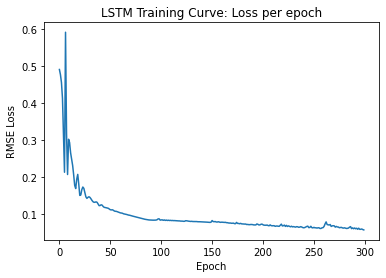

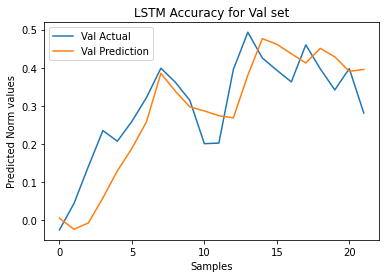

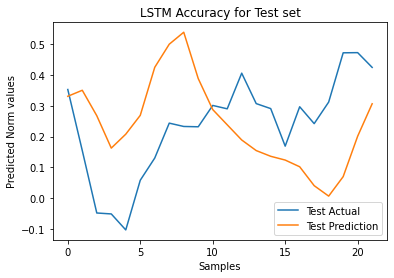

In [27]:
plt.title("LSTM Training Curve: Loss per epoch")
plt.plot(lstm_hist, label="Train")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.show()

lstm_y_val_pred = lstm_model(x_val).detach().numpy()

plt.title("LSTM Accuracy for Val set")
plt.plot(y_val, label="Val Actual")
plt.plot(lstm_y_val_pred, label="Val Prediction")
plt.xlabel("Samples")
plt.ylabel("Predicted Norm values")
plt.legend(loc='best')
plt.show()

lstm_y_test_pred = lstm_model(x_test).detach().numpy()

plt.title("LSTM Accuracy for Test set")
plt.plot(y_test, label="Test Actual")
plt.plot(lstm_y_test_pred, label="Test Prediction")
plt.xlabel("Samples")
plt.ylabel("Predicted Norm values")
plt.legend(loc='best')
plt.show()

# hmm its predicting the same for val and test

In [23]:
'''GRU'''

'GRU'

In [24]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
gru_model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = criterion = RMSLELoss()
optimiser = torch.optim.Adam(gru_model.parameters(), lr=0.01)

In [25]:
import time
gru_hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    gru_y_train_pred = gru_model(x_train)
    loss = criterion(gru_y_train_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "RMSE: ", loss.item())
    gru_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 RMSE:  0.5831928849220276
Epoch  100 RMSE:  0.0846315547823906
Epoch  200 RMSE:  0.08229676634073257
Training time: 7.18542742729187


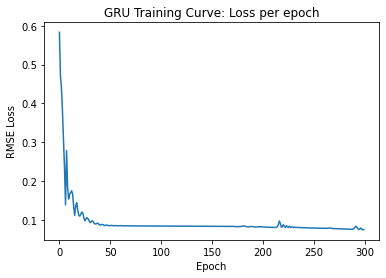

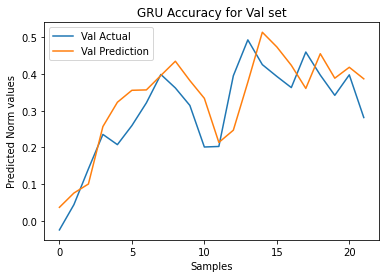

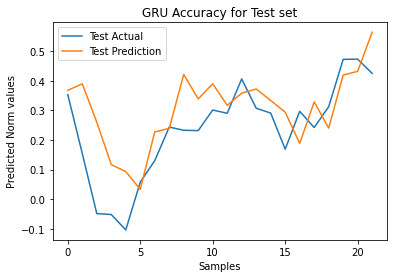

In [30]:
plt.title("GRU Training Curve: Loss per epoch")
plt.plot(gru_hist, label="Train")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.show()

# hmm why predicting the same

gru_y_val_pred = gru_model(x_val).detach().numpy()

plt.title("GRU Accuracy for Val set")
plt.plot(y_val, label="Val Actual")
plt.plot(gru_y_val_pred, label="Val Prediction")
plt.xlabel("Samples")
plt.ylabel("Predicted Norm values")
plt.legend(loc='best')
plt.show()

gru_y_test_pred = gru_model(x_test).detach().numpy()

plt.title("GRU Accuracy for Test set")
plt.plot(y_test, label="Test Actual")
plt.plot(gru_y_test_pred, label="Test Prediction")
plt.xlabel("Samples")
plt.ylabel("Predicted Norm values")
plt.legend(loc='best')
plt.show()